In [1]:
import firedrake
import hydropack
from hydropack.constants import *
from hydropack.cr_tools import *
from hydropack.models import glads
from hydropack.models.glads import Glads2DModel

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


# Hydropack
The goal of this notebook is to identify some of the key ingredients of subglacial hydrology model and use these to understand some of the existing models and develop a simple model that can be easily coupled to an ice sheet model.

In [2]:
Lx, Ly = 60e3,20e3
nx,ny = 48, 32
mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)

In [3]:
Q = firedrake.FunctionSpace(mesh,"CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)
CR = firedrake.FunctionSpace(mesh, "CR",1)

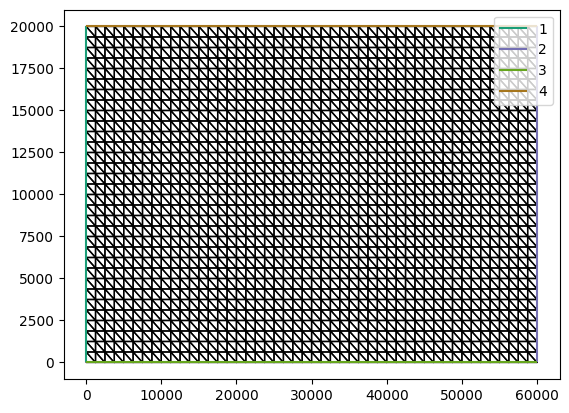

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
firedrake.triplot(mesh, axes=axes)
axes.legend();
#fig.savefig('mesh.png',dpi=200)

In [5]:
# Initial sheet height
h_init = firedrake.Function(Q);
h_init.interpolate(firedrake.Constant(0.03));

# Hydrology and ice flow
We know from observations of glacier surface velocity that the subglacial hydrology system can impact surface flow velocity. Icepack solves for velocity in meters per year where as these hydrology models typically represent fluxes in seconds.

In [6]:
x, y = firedrake.SpatialCoordinate(mesh);

u_b = firedrake.Function(Q);
u_b = firedrake.interpolate((50 + 250 * (60000 - x) / 60000) / 31536000, Q);

/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


In [7]:
# Initial channel areas
S_init = firedrake.Function(CR)
S_init = firedrake.interpolate(firedrake.Constant(.00001),CR)
# Initial potential
phi_init = firedrake.Function(Q)
phi_init = firedrake.interpolate(firedrake.Constant(.0000001),Q)

# potential
phi = firedrake.Function(Q)
phi_prev = firedrake.Function(Q)

melt = firedrake.Function(Q)
melt = firedrake.interpolate(0.5 * (1.0 + (4.0 * (60000.0 - x) / 60000.0)) / 31536000.0, Q)

/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpola

In [8]:
bed = firedrake.Function(Q)
bed = firedrake.interpolate(firedrake.Constant(0.0),Q)

h_max=1400.0
thickness = firedrake.Function(Q)
thickness = firedrake.interpolate(firedrake.sqrt((x + 50.0) * h_max**2 / Lx),Q)

p_i = firedrake.Function(Q)
p_i = firedrake.interpolate(ice_density * gravity * thickness, Q)

phi_m = firedrake.Function(Q)
phi_m = firedrake.interpolate(water_density * gravity * bed, Q)

phi_0 = firedrake.Function(Q)
phi_0 = firedrake.interpolate(p_i + phi_m, Q)

N = firedrake.Function(Q)
N = firedrake.interpolate(phi_0 - phi,Q)

/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpola

In [9]:
bc = firedrake.DirichletBC(Q,phi_0,1)

# Overview of synthetic outlet glacier
Here we plot the thickness, and velocity of the glacier catchment that we aim to simulate with our subglacial hydrology model.

/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.


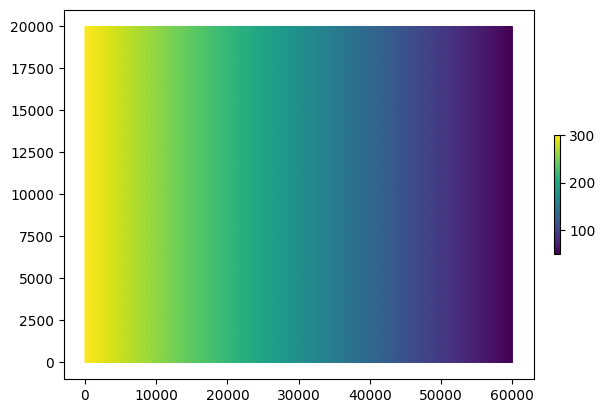

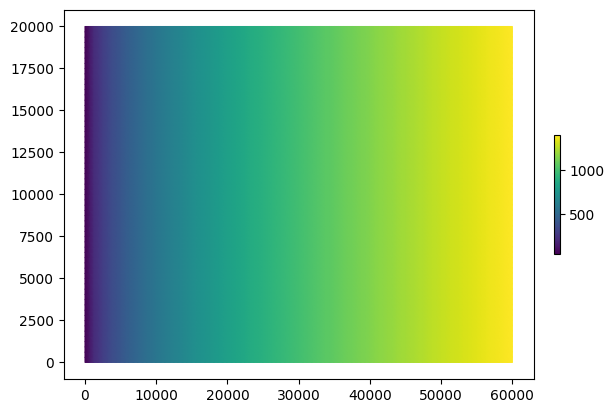

In [10]:
fig, axes = plt.subplots()
colors = firedrake.tripcolor(firedrake.interpolate(u_b * 31536000.0,Q), axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

fig, axes = plt.subplots()
colors = firedrake.tripcolor(thickness, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

In [11]:
model_inputs = {}
model_inputs['mesh'] = mesh
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['thickness'] = thickness
model_inputs['bed'] = bed
model_inputs['u_b'] = u_b
model_inputs['m'] = melt
model_inputs['phi_prev'] = phi_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_0
model_inputs['constants'] = pcs


# Create the Glads model
model = Glads2DModel(model_inputs)

/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpolate` to perform the numerical interpolation is deprecated.
This feature will be removed very shortly.

Instead, import `interpolate` from the `firedrake.__future__` module to update
the interpolation's behaviour to return the symbolic `ufl.Interpolate` object associated
with this interpolation.

You can then assemble the resulting object to get the interpolated quantity
of interest. For example,

```
from firedrake.__future__ import interpolate
...

assemble(interpolate(expr, V))
```

Alternatively, you can also perform other symbolic operations on the interpolation operator, such as taking
the derivative, and then assemble the resulting form.

  warnings.warn("""The use of `interpolate` to perform the numerical interpolation is deprecated.
/home/andrew/venv-firedrake/lib/python3.10/site-packages/firedrake/interpolation.py:391: FutureWarning: The use of `interpola

In [12]:
from hydropack.models.glads import Glads2DModel

In [ ]:
model_inputs = {}
model_inputs['mesh'] = mesh
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['thickness'] = thickness
model_inputs['bed'] = bed
model_inputs['u_b'] = u_b
model_inputs['m'] = melt
model_inputs['phi_prev'] = phi_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_0
model_inputs['constants'] = pcs


# Create the Glads model
model = glads.Glads2DModel(model_inputs)

In [16]:
model_inputs = {}
model_inputs['mesh'] = mesh
model_inputs['h_init'] = h_init
model_inputs['S_init'] = S_init
model_inputs['thickness'] = thickness
model_inputs['bed'] = bed
model_inputs['u_b'] = u_b
model_inputs['m'] = melt
model_inputs['phi_prev'] = phi_init
model_inputs['phi_init'] = phi_init
model_inputs['d_bcs'] = [bc]
model_inputs['phi_m'] = phi_m
model_inputs['p_i'] = p_i
model_inputs['phi_0'] = phi_0
model_inputs['constants'] = pcs


# Create the Glads model
model = glads.Glads2DModel(model_inputs)

TypeError: Vector.__init__() missing 1 required positional argument: 'x'

In [13]:
# Seconds per day
spd = pcs['spd']
# End time
T = 10.0 * spd
# Time step
dt = 60.0 * 30.0
# Irataion count
i = 0

while model.t < T:
    current_time = model.t / spd
    print("Current Time: " + str(current_time))
    model.step(dt)
    if i % 24 == 0:
        model.write_pvds()
  

Current Time: 0.0


ValueError: Discontinuous type Coefficient must be restricted.